In [1]:
!pip install freud-analysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import freud # для создания диаграммы Вороного
import networkx as nx # для создания матрицы смежности

In [3]:
def generate_points(N):
    points = np.vstack((np.random.uniform(0, 1, N, ), np.random.uniform(0, 1, N))).T # generate uniformly distributed points in [0,1]^2
    points = np.hstack((points, np.zeros((N, 1)))) # add z=0 component for freud
    box = freud.box.Box(Lx=1, Ly=1, is2D=True)
    points = box.wrap(points)
    return box, points

In [4]:
def normalization(coord): # нужно закодировать каждую вершину, желательно убирая эффекты арифметики с плавающей точкой
    x = coord[0]
    if x < -0.5:
        x += 1.
    elif x > 0.5:
        x -= 1.
    y = coord[1]
    if y < -0.5:
        y += 1.
    elif y > 0.5:
        y -= 1.
    return (str(round(x, 8)) + " " + str(round(y, 8))) # для этого я храню координаты как строки с заранее заданной точностью
                                                       # (если есть ошибка, можно пропустить и не парить мозги)

In [5]:
def get_vertices(cells): # нужно получить список вершин, чтобы потом обращаться к нему и записывать ребра
    vertices = np.concatenate(cells)
    vertices2 = np.asarray([normalization(x) for x in vertices])
    return {x: i for i,x in enumerate(sorted(vertices2)[::3])} # здесь использую, что графы получаются 3-регулярными, если не получился, то undefined behaviour ИСПРАВИТЬ

In [6]:
def transform(cells): # функция сделана для удобства
    ans = []
    for cell in cells:
        ans.append([normalization(x) for x in cell])
    return ans

In [7]:
def get_edges(vertices, transformed_cells): # собираю список ребер, из которого потом получим граф
    edges = []
    for cell in transformed_cells:
        cell = cell.copy()
        l = len(cell)
        cell.append(cell[0])
        for i in range(l):
            edge = (vertices.get(cell[i]), vertices.get(cell[i+1]))
            edges.append(edge)
    return edges # не смотрели на повторы ребер, но потом матрица смежности их не учитывает

In [8]:
def voronoi_adjacency_matrix(N): # засунул все в одну функцию
    box, points = generate_points(N)
    voro = freud.locality.Voronoi()
    cells = voro.compute((box, points)).polytopes

    vertices = get_vertices(cells)
    transformed_cells = transform(cells)

    edgelist = get_edges(vertices, transformed_cells)
    G = nx.Graph(edgelist)
    A = nx.adjacency_matrix(G)
    #nx.draw(G)
    degrees = np.sum(A, axis=1)
    if np.all(degrees == 3):
      return A.toarray()
    else:
      return np.empty((0,0))

In [9]:
from collections import defaultdict

In [11]:
pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.8 MB/s eta 0:00:00


In [13]:
pip install pynauty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pynauty: filename=pynauty-2.8.8.1-cp311-cp311-linux_x86_64.whl size=181870 sha256=727e0d0e45bd86511d1c095f3bfdd3328b06718593dc34ac351116c06f2526e2
  Stored in directory: /root/.cache/pip/wheels/c1/e3/ba/722f2d9187889ac73ce949422b5b698450d8d1390b479adab8
Successfully built pynauty


In [14]:
import pynauty

def graph_to_canonical_form(adj_matrix, adj_list):
    """
    Переводит граф, заданный матрицей смежности, в каноническую форму с помощью nauty.
    Возвращает каноническую матрицу.
    """
    n = adj_matrix.shape[0]

    edges = [(i, j) for i in range(n) for j in range(i+1, n) if adj_matrix[i,j]!=0]

    # Создаем граф из матрицы
    adj_dict = {}

    # Проходим по списку рёбер и заполняем словарь
    for u, v in edges:
        # Добавляем v в список смежных вершин для u
        if u not in adj_dict:
            adj_dict[u] = []
        adj_dict[u].append(v)

        # Так как граф неориентированный, добавляем u в список для v
        if v not in adj_dict:
            adj_dict[v] = []
        adj_dict[v].append(u)

    g = pynauty.Graph(
        number_of_vertices=n,
        adjacency_dict=adj_dict,
        directed=False
    )

    # Получаем каноническую нумерацию вершин
    canon_labeling = pynauty.canon_graph(g)
    #print(canon_labeling)

    adj_dict = canon_labeling.adjacency_dict

    adj_list.append(adj_dict) #список словарей смежности

    # Преобразуем в кортежи с отсортированными списками
    hashable_representation = tuple(
        (node, tuple(sorted(neighbors)))
        for node, neighbors in sorted(adj_dict.items())
    )

    # Получаем хэш
    hash_value = hash(hashable_representation)

    return hash_value

In [16]:
matrices = [
      [[0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [1, 1, 0, 0, 1, 0]],
      [[0, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0]],
      [[0, 1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 0, 0]],
      [[0, 1, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1],
       [0, 0, 1, 1, 1, 0]]
      ]

groups = defaultdict(list)

l = []

for idx, adj in enumerate(matrices):
    adj_np = np.array(adj)
    form = graph_to_canonical_form(adj_np, l)
    groups[form].append(idx)


In [17]:
for class_id, (form_key, graph_indices) in enumerate(groups.items(), 1):
    print(f"Класс {class_id}: графы с индексами {graph_indices}")

Класс 1: графы с индексами [0, 1, 2, 3]


In [18]:
#Получим статистику для 1000 графов с 10 вершинами

matrices = []
i = 0

l_adj = []

while i < 1000:
  m = voronoi_adjacency_matrix(5)
  if m.shape != (0,0):
    matrices.append(m)
    i+=1

# Группировка по изоморфным классам
groups = defaultdict(list)


for idx, adj in enumerate(matrices):
    adj_np = np.array(adj)
    form = graph_to_canonical_form(adj_np, l_adj)
    groups[form].append(idx)

# Вывод результатов
for class_id, (form_key, graph_indices) in enumerate(groups.items(), 1):
    print(f"Класс {class_id}: графы с индексами {graph_indices}")

Класс 1: графы с индексами [0, 3, 8, 9, 10, 13, 14, 15, 17, 19, 22, 23, 25, 28, 29, 36, 39, 40, 45, 47, 49, 53, 54, 55, 56, 58, 59, 60, 61, 63, 65, 67, 69, 70, 71, 72, 74, 75, 76, 80, 81, 85, 86, 87, 91, 95, 96, 97, 98, 99, 101, 102, 103, 106, 107, 108, 109, 114, 115, 116, 117, 118, 122, 125, 131, 133, 136, 140, 145, 147, 148, 149, 150, 151, 155, 157, 159, 161, 162, 163, 165, 168, 169, 170, 172, 173, 175, 177, 178, 180, 181, 182, 183, 186, 187, 189, 190, 191, 196, 198, 202, 204, 207, 208, 209, 212, 214, 215, 216, 217, 218, 221, 222, 225, 226, 227, 228, 230, 231, 233, 235, 236, 240, 242, 244, 248, 249, 251, 252, 253, 255, 258, 259, 262, 263, 268, 269, 271, 272, 273, 277, 278, 284, 288, 290, 292, 295, 296, 298, 299, 300, 301, 304, 306, 307, 308, 310, 311, 312, 315, 316, 317, 319, 323, 324, 325, 326, 334, 336, 337, 338, 339, 343, 345, 346, 347, 349, 351, 352, 354, 355, 356, 360, 361, 362, 364, 366, 367, 368, 369, 370, 371, 376, 380, 381, 382, 383, 384, 385, 388, 389, 391, 392, 393, 394, 3

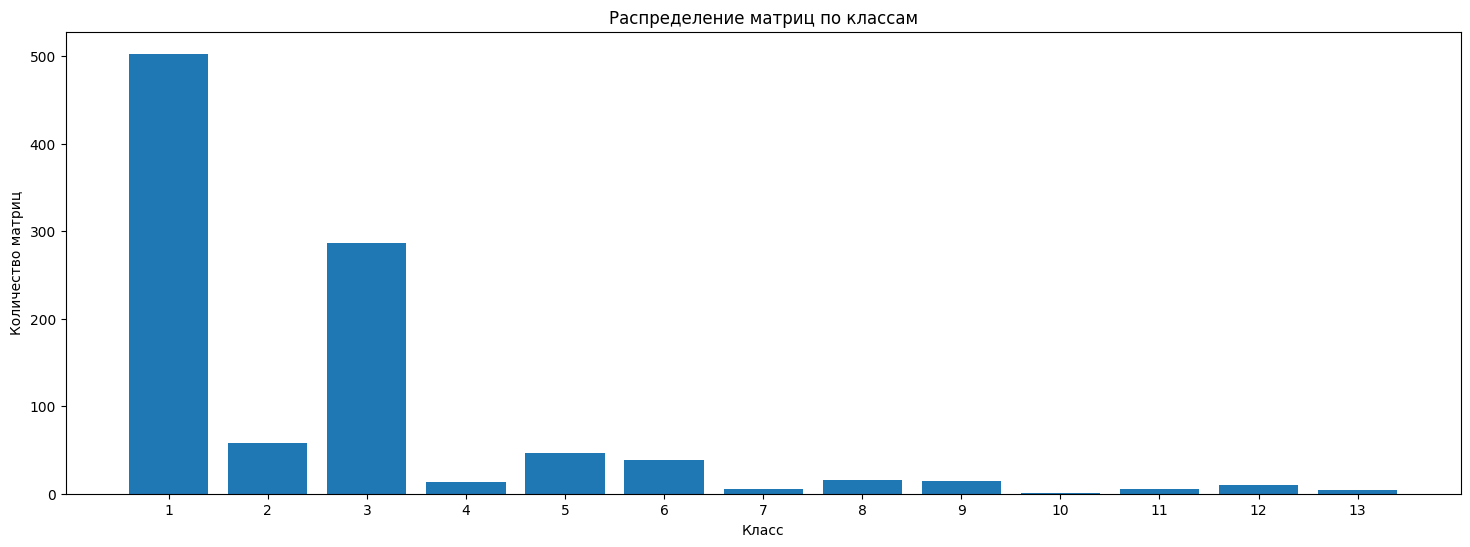

In [19]:
#Получим гистограмму

# Получаем список размеров групп (число матриц в каждом классе)
group_sizes = [len(indices) for indices in groups.values()]

# Названия классов — можно оставить просто номера или использовать ключи
class_labels = [f"{i+1}" for i in range(len(group_sizes))]

# Построение гистограммы
plt.figure(figsize=(18, 6))
plt.bar(class_labels, group_sizes, width = 0.8)
plt.xlabel('Класс')
plt.ylabel('Количество матриц')
plt.title('Распределение матриц по классам')
plt.show()

In [20]:
#Словарь смежности самого популярного графа

print(l_adj[0])

{0: [1, 2, 3], 1: [0, 8, 9], 2: [0, 9, 7], 3: [0, 5, 6], 4: [8, 5, 6], 5: [9, 3, 4], 6: [3, 4, 7], 7: [8, 2, 6], 8: [1, 4, 7], 9: [1, 2, 5]}


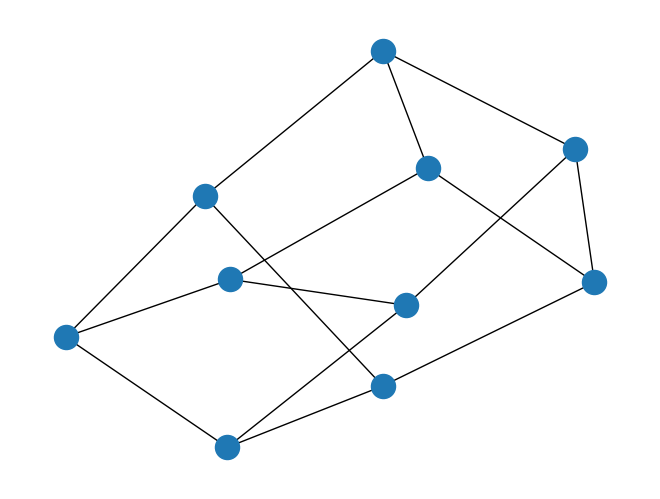

In [22]:
adj_dict = l_adj[0]
G = nx.Graph(adj_dict)
nx.draw(G)

In [27]:
peterson_adj_dict = {
    0: [1, 4, 5],
    1: [0, 2, 6],
    2: [1, 3, 7],
    3: [2, 4, 8],
    4: [0, 3, 9],
    5: [0, 7, 8],
    6: [1, 8, 9],
    7: [2, 5, 9],
    8: [3, 5, 6],
    9: [4, 6, 7]
}

g = pynauty.Graph(
        number_of_vertices=10,
        adjacency_dict=peterson_adj_dict,
        directed=False
    )

canon_labeling = pynauty.canon_graph(g)

adj_dict = canon_labeling.adjacency_dict

print(adj_dict)

#Первый граф петерсона в выборке
print(l_adj.index(adj_dict))

{0: [1, 2, 3], 1: [0, 4, 5], 2: [0, 9, 6], 3: [0, 8, 7], 4: [8, 1, 6], 5: [1, 9, 7], 6: [2, 4, 7], 7: [3, 5, 6], 8: [9, 3, 4], 9: [8, 2, 5]}
156
